# Exploratory Data Analysis for Randomized Redistricting

This Jupyter notebook documents all steps that encompass the Exploratory Data Analysis (EDA) phase of the [random-redistricter](https://github.com/sherwinhlee/random-redistricter) project. Tasks include data pre-processing, wrangling, mining, and everything in-between. The input is the raw election returns file from MIT Election Data and Science Lab. The output will be a dataset that can be used for vote aggregation when the new districts are drawn.

Last updated: November 29, 2018

In [23]:
import matplotlib as plt
import numpy as np
import pandas as pd
import os

parent = os.path.realpath('..')  # Working repo directory
file = '2016-precinct-house.csv'  # Filename of election returns
df = pd.read_csv(parent + '\\data\\raw\\' + file, encoding='ISO-8859-1')  # Read .csv into dataframe

C:\Users\Sherwin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Since we'll end up dropping the offending columns from the dataframe, we'll ignore the data type warning above. Next steps are to do very surface-level EDA tasks, like seeing how many missing values we have to indeed verify that this dataset is only for the 2016 general election.

In [24]:
df.isnull().sum()  # Number of empty rows per column

year                           0
stage                          0
special                        0
state                          0
state_postal                   0
state_fips                     0
state_icpsr                    0
county_name                 3858
county_fips                 3246
county_ansi                 3858
county_lat                  3858
county_long                 3858
jurisdiction                   0
precinct                       0
candidate                   4922
candidate_normalized        4922
office                         0
district                   34607
writein                        0
party                     213192
mode                           0
votes                          0
candidate_opensecrets     737640
candidate_wikidata        737640
candidate_party           737640
candidate_last            737640
candidate_first           737640
candidate_middle          947195
candidate_full            737640
candidate_suffix         1113939
candidate_

In [25]:
print(df['year'].unique())  # Verify only 2016 election
print(df['stage'].unique())  # Verify only general, not primary, election

[2016]
['gen']


In [26]:
df['party'].unique()  # List unique parties

array([nan, 'democratic', 'republican', "people's party", 'libertarian',
       'new alliance', 'green', 'independent', 'working families',
       'dc statehood green', 'none', 'nonpartisan', 'constitution',
       'nominated by petition', 'american delta', 'NOPTY', 'OTHER',
       'unaffiliated', 'BOT', 'unenrolled', 'us taxpayers',
       'natural law party', 'WCP', 'Democratic-Farmer-Labor',
       'Legal Marijuana Now', 'Independence', 'veterans', 'reform',
       'independent american', "people's independent progressive",
       'representing the 99%', 'for political revolution',
       'make government work', 'wake up america', 'nsa did 911',
       'american independents', 'we deserve better',
       'financial independence', 'new beginnings', 'women of power',
       'conservative', "women's equality", 'independence',
       'transparent government', "people's choice", 'upstate jobs',
       'stop the iran deal', 'Harris Bhatti', 'blue lives matter',
       'democrat', 'republi

Since there are currently no Independents in Congress, a simplifying assumption is that we ignore third-party candidates. Ultimately, this project is concerned with the power balance in a two-party system. As you can see above, there are lots of third parties, all of which we will drop. Similarly, we will also drop write-in votes, which is predicated on the reasonable assumption that there has not been a major successful write-in campaign in a while.

In [27]:
# Drop third-party candidates (IN PROGRESS)
df = df.drop(df[df['writein']].index)  # Drop write-ins
# Merge party and candidate_party columns (IN PROGRESS)

As a corollary to the previous step, another major pre-processing stop is to ensure that all records we work with have a political party, specific Democrat or Republican. With this massive dataset, we will invariably have many records that lack a value for political party. There are two steps to get around this:
1. **Dropping "inconsequential" records** - removing records that aren't even actual candidates, missed write-in candidates, and non-serious candidates who have very few votes.
2. **Imputing political party** - checking to see if candidates have other records where a party is assigned and if not, then manually imputing them through quick search engine queries. 

In [28]:
no_party = df[df['party'].isnull() & df['candidate_party'].isnull()]  # Create df of records with no party (CHOPPING BLOCK)
print(len(no_party),'records do not have a political party.')  # Number of records with no value for party

88083 records do not have a political party.


In [29]:
no_party['candidate'].unique()  # List of unique names of remaining candidates

array(['Brianna Barksdale', 'Brian Deshazo', 'J M Grogan',
       'Kent J McGrew', 'For', 'FOR', 'FOR ALL THE UNOPPOSED CANDIDATES.',
       'FOR UNOPPOSED', 'VOTE FOR', 'FOR ALL UNOPPOSED',
       'FOR Unopposed Candidates', 'VOTE FOR ALL',
       'Roman Gabriel Gonzalez', 'Preston Picus', 'Curtis Imrie',
       'Robert Nelson Franz III', 'Rachelle Lee Linney', 'Campbell Smith',
       'Scott Walker', 'Nathan Russo', 'Leonard Ware',
       'JAMES NEAL HARRIS', 'GREG DUKE', 'PATRICIA C. MCCRACKEN',
       'Patrick A. Boggs', 'DON WILSON', 'ANGELA PENDLEY', 'DOUGLAS BELL',
       'RODNEY STOOKSBURY', 'RASHID MALIK', 'VICTOR ARMENDARIZ',
       'MARK D. WICKLUND', 'ROB SHERMAN', 'PATRICK HARLAN', 'James Bales',
       'Britani Potter', 'Samuel L. GASKINS', 'Nancy Jo KEMPER',
       'Calvin SIDLE', 'STRAIGHT PARTY', 'Calvin Sidle',
       'Harold BRATCHER', 'Dresser, Jay Parker', 'HOLBROOK', 'All Others',
       'OVERTON, RICHARD MILLER', 'ARNOLD, JOSHUA', 'BENTIVOLIO, KERRY',
       'LYN

As it appears, there are a lot of election "candidates" that aren't really candidates at all. Stuff like "SCATTER" and "Affidavit" inevitably show up throughout the massive data compilation process. The step below creates an array of all values that are clearly non-person entities. All records matching these values are then dropped - we will assume these are inconsequential to the overall analysis.

In [30]:
# Set of non-person candidate names for removal
nh = np.array(['For', 'FOR', 'FOR ALL THE UNOPPOSED CANDIDATES.',
       'FOR UNOPPOSED', 'VOTE FOR', 'FOR ALL UNOPPOSED',
       'FOR Unopposed Candidates', 'VOTE FOR ALL', 'STRAIGHT PARTY', 
       'All Others', 'Scatter', 'Personal Choice', 'Scattering', 
       'Affidavit', 'Manually Counted Emergency', 'Federal', 
       'Absentee/Military', 'Special Presidential', 'Special Votes', 
       'SCATTERING'], dtype=object)

no_party = no_party.drop(no_party[no_party['candidate'].isin(nh)].index)  # Drop records with non-person candidate values

In [31]:
# for remaining records, do candidates exist in the main df with associated party values?
# throw out records that wouldn't make much a statistical difference?

The array below lists the resulting set of unique candidate names who don't have an associated party. Names are rendered lower-case to get around case-sensitivity issues. As we can see, some names are evidently not actual candidates, like Ben Affleck, who I wasn't aware ran for Congress. These were most likely write-ins but did not get flagged as such. Just for kicks, let's plot the number of votes that these remaining candidates got.

In [32]:
no_party['candidate'] = no_party['candidate'].str.lower()
no_party['candidate'].unique()

array(['brianna barksdale', 'brian deshazo', 'j m grogan',
       'kent j mcgrew', 'roman gabriel gonzalez', 'preston picus',
       'curtis imrie', 'robert nelson franz iii', 'rachelle lee linney',
       'campbell smith', 'scott walker', 'nathan russo', 'leonard ware',
       'james neal harris', 'greg duke', 'patricia c. mccracken',
       'patrick a. boggs', 'don wilson', 'angela pendley', 'douglas bell',
       'rodney stooksbury', 'rashid malik', 'victor armendariz',
       'mark d. wicklund', 'rob sherman', 'patrick harlan', 'james bales',
       'britani potter', 'samuel l. gaskins', 'nancy jo kemper',
       'calvin sidle', 'harold bratcher', 'dresser, jay parker',
       'holbrook', 'overton, richard miller', 'arnold, joshua',
       'bentivolio, kerry', 'lynch, clyde darnell', 'david h. cole',
       'steven fenichel', 'james keenan', 'john ordille',
       'eric beechwood', 'gabriel brian franco',
       'lawrence w. berlinski,jr', 'frederick john lavergne',
       'michael

This step groups all candidates, summing up votes, and plots so we can see just how many votes we are talking about...

Create pivot table instead of rem and sum up votes but average the districts. Then compare vote totals to the district total in remaining dataset. This is how we measure inconsequentiality.

THINK ABOUT IMPUTING FIRST THEN MEASURING INCONSEQUENTIALITY

Might be best to do a grouping of the districts of these remaining candidates and look up the unique candidates of those districts to see if there exists an existing Democrat/Republican

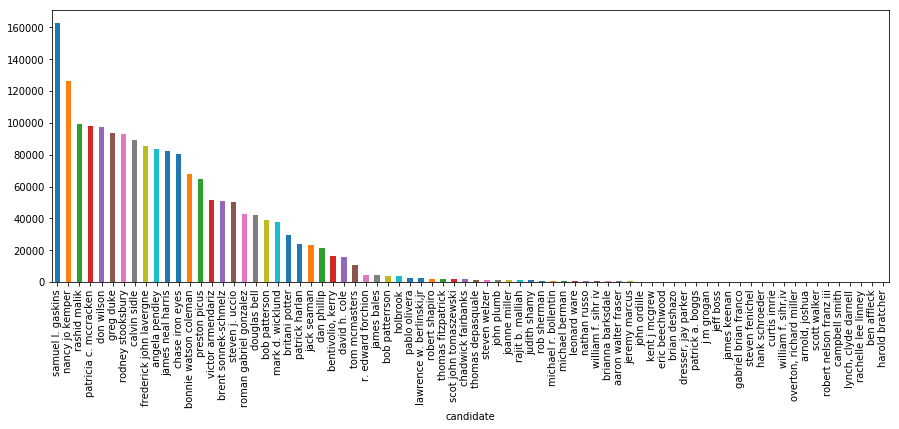

In [33]:
rem = no_party.groupby(no_party['candidate'].str.lower()).sum().sort_values(['votes'],ascending=False)  # Group candidates and sum votes
plt.rcParams['figure.figsize'] = [15, 5]  # Plot figure dimensions
rem['votes'].plot(kind="bar")  # Plot votes in descending order

As it appears, a lot of these candidates got a sizeable number of votes, some in the order of hundreds of thousands. So it appears we can't discount many of these. The next step is to find the districts these candidates are in and then see how the plotted vote totals stack up to the vote totals in the main dataset. To make things easier, we'll create a new dataframe retaining only the columns relevant for our analysis.

This step lets us figure out if the candidates do have existing records with non-empty values for political party. If they do, then we can easily impute the missing party. If not, then we'll need to make an estimation on whether the candidate is a Democrat or Republican - if likely neither, then we can safely drop the records from consideration.

In [34]:
rem_pt = pd.pivot_table(no_party, values='district', index=['candidate','state_postal'], aggfunc=np.mean)
rem_lkup = pd.DataFrame(rem_pt).reset_index()  # Convert pivot table to dataframe lookup table
rem_lkup

,candidate,state_postal,district
0,aaron walter fraser,NJ,10.0
1,angela pendley,GA,3.0
2,"arnold, joshua",MI,2.0
3,ben affleck,NY,27.0
4,"bentivolio, kerry",MI,11.0
5,bob patterrson,NJ,1.0
6,bob patterson,NJ,1.0
7,bonnie watson coleman,NJ,12.0
8,brent sonnek-schmelz,NJ,6.0
9,britani potter,KS,2.0


In [35]:
# Create new dataframe with relevant columns
df2 = df[['state_postal','state_fips','county_fips',
          'jurisdiction','precinct','candidate','district',
          'party','votes','candidate_party']]

# Loop through lookup table and print candidates + results for those districts
for idx, row in rem_lkup.iterrows():
    match = df2[(df2['state_postal']==row[1]) & (df2['district']==row[2])]
    print(row[0], row[1], row[2])
    print(pd.pivot_table(match, values='votes', index=['candidate'], columns='party', aggfunc=np.sum),'\n')
    

aaron walter fraser NJ 10.0
party                 democratic  new beginnings  nonpartisan  republican  \
candidate                                                                   
Aaron Walter FRASER          NaN             NaN        320.0         NaN   
Aaron Walter Fraser          NaN           945.0          NaN         NaN   
David H. PINCKNEY            NaN             NaN          NaN     10424.0   
David H. Pinckney            NaN             NaN          NaN     16096.0   
Donald M. PAYNE, JR.     38822.0             NaN          NaN         NaN   
Donald M. Payne Jr.     152572.0             NaN          NaN         NaN   
Joanne MILLER                NaN             NaN        717.0         NaN   
Joanne Miller                NaN             NaN          NaN         NaN   

party                 women of power  
candidate                             
Aaron Walter FRASER              NaN  
Aaron Walter Fraser              NaN  
David H. PINCKNEY                NaN  
David 

curtis imrie CO 5.0
party            democratic  libertarian  republican
candidate                                           
Doug Lamborn            NaN          NaN    225445.0
Mike McRedmond          NaN      24872.0         NaN
Misty Plowright    111676.0          NaN         NaN 

dan phillip OH 7.0
party      democratic  republican
candidate                        
Bob Gibbs         NaN    198221.0
Roy Rich      89638.0         NaN 

david h. cole NJ 2.0
party                 democratic  for political revolution  independent  \
candidate                                                                 
David Cole               45898.0                       NaN          NaN   
David H. COLE             5882.0                       NaN          NaN   
David H. Cole            43384.0                       NaN          NaN   
Eric BEECHWOOD               NaN                       NaN         86.0   
Eric Beechwood               NaN                       NaN          NaN   
Frank A. L

frederick john lavergne NJ 3.0
party                     democratic  independent  republican
candidate                                                    
Frederick John LaVERGNE      41766.0          NaN         NaN
Lawrence W. BERLINSKI JR         NaN       3513.0         NaN
Tom MacARTHUR                    NaN          NaN     95147.0 

gabriel brian franco NJ 2.0
party                 democratic  for political revolution  independent  \
candidate                                                                 
David Cole               45898.0                       NaN          NaN   
David H. COLE             5882.0                       NaN          NaN   
David H. Cole            43384.0                       NaN          NaN   
Eric BEECHWOOD               NaN                       NaN         86.0   
Eric Beechwood               NaN                       NaN          NaN   
Frank A. LoBIONDO            NaN                       NaN          NaN   
Frank A. LoBiondo            

james keenan NJ 2.0
party                 democratic  for political revolution  independent  \
candidate                                                                 
David Cole               45898.0                       NaN          NaN   
David H. COLE             5882.0                       NaN          NaN   
David H. Cole            43384.0                       NaN          NaN   
Eric BEECHWOOD               NaN                       NaN         86.0   
Eric Beechwood               NaN                       NaN          NaN   
Frank A. LoBIONDO            NaN                       NaN          NaN   
Frank A. LoBiondo            NaN                       NaN          NaN   
Frank LoBiondo               NaN                       NaN          NaN   
Gabriel Brian FRANCO         NaN                       NaN         70.0   
Gabriel Brian Franco         NaN                     264.0          NaN   
Gabriel Franco               NaN                     397.0          NaN   
James

john ordille NJ 2.0
party                 democratic  for political revolution  independent  \
candidate                                                                 
David Cole               45898.0                       NaN          NaN   
David H. COLE             5882.0                       NaN          NaN   
David H. Cole            43384.0                       NaN          NaN   
Eric BEECHWOOD               NaN                       NaN         86.0   
Eric Beechwood               NaN                       NaN          NaN   
Frank A. LoBIONDO            NaN                       NaN          NaN   
Frank A. LoBiondo            NaN                       NaN          NaN   
Frank LoBiondo               NaN                       NaN          NaN   
Gabriel Brian FRANCO         NaN                       NaN         70.0   
Gabriel Brian Franco         NaN                     264.0          NaN   
Gabriel Franco               NaN                     397.0          NaN   
James

nancy jo kemper KY 6.0
party            democratic  republican
candidate                              
Andy Barr               NaN      5968.0
Nancy Jo Kemper      2402.0         NaN 

nathan russo GA 1.0
party                    republican
candidate                          
EARL âBUDDYâ CARTER        3281 

overton, richard miller MI 6.0
party           democratic  libertarian  republican
candidate                                          
CLEMENTS, PAUL    119766.0          NaN         NaN
UPTON, FRED            NaN          NaN    192725.0
WENKE, LORENCE         NaN      16215.0         NaN 

pablo olivera NJ 8.0
party          democratic  libertarian  nonpartisan  republican  \
candidate                                                         
Agha KHAN             NaN          NaN          NaN      3463.0   
Agha Khan             NaN          NaN          NaN     28874.0   
Albio SIRES       18807.0          NaN          NaN         NaN   
Albio Sires      115926.0          N

steven fenichel NJ 2.0
party                 democratic  for political revolution  independent  \
candidate                                                                 
David Cole               45898.0                       NaN          NaN   
David H. COLE             5882.0                       NaN          NaN   
David H. Cole            43384.0                       NaN          NaN   
Eric BEECHWOOD               NaN                       NaN         86.0   
Eric Beechwood               NaN                       NaN          NaN   
Frank A. LoBIONDO            NaN                       NaN          NaN   
Frank A. LoBiondo            NaN                       NaN          NaN   
Frank LoBiondo               NaN                       NaN          NaN   
Gabriel Brian FRANCO         NaN                       NaN         70.0   
Gabriel Brian Franco         NaN                     264.0          NaN   
Gabriel Franco               NaN                     397.0          NaN   
Ja

thomas depasquale NJ 11.0
party                    democratic  financial independence  independent  \
candidate                                                                  
Jeff HETRICK                    NaN                     NaN        655.0   
Jeff Hetrick                    NaN                     NaN          NaN   
Joseph M. WENZEL            20919.0                     NaN          NaN   
Joseph M. Wenzel           109243.0                     NaN          NaN   
Rodney P. FRELINGHUYSEN         NaN                     NaN          NaN   
Rodney P. Frelinghuysen         NaN                     NaN          NaN   
Thomas DePASQUALE               NaN                     NaN       2287.0   
Thomas DePasquale               NaN                  3129.0          NaN   

party                    libertarian  republican  
candidate                                         
Jeff HETRICK                     NaN         NaN  
Jeff Hetrick                  2820.0         NaN  
Joseph M.